# How to fine tune a Ridge/Lasso model with sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, get_scorer
from sklearn.linear_model import Lasso, Ridge, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_validate, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
pd.options.display.float_format = '{:,.2f}'.format


In [3]:
column_names = \
    ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
     'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [4]:
data = pd.read_csv("housing.csv", delimiter=r"\s+", header=None, names=column_names)
y = data['MEDV']
X = data.drop(['MEDV'], axis=1)

In [5]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.01,18.00,2.31,0,0.54,6.58,65.20,4.09,1,296.00,15.30,396.90,4.98
1,0.03,0.00,7.07,0,0.47,6.42,78.90,4.97,2,242.00,17.80,396.90,9.14
2,0.03,0.00,7.07,0,0.47,7.18,61.10,4.97,2,242.00,17.80,392.83,4.03
3,0.03,0.00,2.18,0,0.46,7.00,45.80,6.06,3,222.00,18.70,394.63,2.94
4,0.07,0.00,2.18,0,0.46,7.15,54.20,6.06,3,222.00,18.70,396.90,5.33


In [6]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.42,-0.49,-1.56,-0.27,-1.47,-3.88,-2.34,-1.27,-0.98,-1.31,-2.71,-3.91,-1.53
25%,-0.41,-0.49,-0.87,-0.27,-0.91,-0.57,-0.84,-0.81,-0.64,-0.77,-0.49,0.21,-0.80
50%,-0.39,-0.49,-0.21,-0.27,-0.14,-0.11,0.32,-0.28,-0.52,-0.46,0.27,0.38,-0.18
75%,0.01,0.05,1.02,-0.27,0.60,0.48,0.91,0.66,1.66,1.53,0.81,0.43,0.60
max,9.93,3.80,2.42,3.67,2.73,3.56,1.12,3.96,1.66,1.80,1.64,0.44,3.55


In [7]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0.00001, 0.2, 21)

lasso = Lasso()
grid = dict(alpha=lasso_alphas)
gscv = GridSearchCV(lasso, grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error')
results = gscv.fit(X_scaled, y)



In [8]:
print(f"Best alpha: {results.best_estimator_.alpha}")
print(f"Best score: {-results.best_score_:.4f}")
print(f"Best params: {results.best_params_}")

Best alpha: 0.080006
Best score: 3.3508
Best params: {'alpha': 0.080006}


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

In [10]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0.00001, 0.2, 21)

lasso = Lasso()
grid = dict(alpha=lasso_alphas)
gscv = GridSearchCV(lasso, grid, cv=cv, n_jobs=-1,
                    scoring='neg_mean_absolute_error')



In [11]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0.00001, 0.2, 21)

lassos = [Lasso(alpha=alpha) for alpha in lasso_alphas]
train_scores = [abs(cross_val_score(lassos[i], X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')).mean() for i in range(len(lassos))]

In [12]:
test_scores = [abs(cross_val_score(lassos[i], X_test, y_test, cv=cv, scoring='neg_mean_absolute_error')).mean() for i in range(len(lassos))]

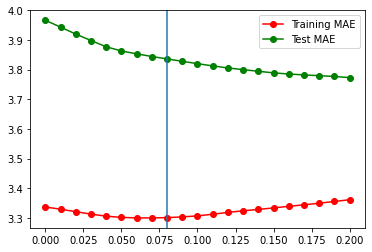

In [13]:
plt.plot(lasso_alphas, train_scores, 'o-', color='r', label='Training MAE')
plt.plot(lasso_alphas, test_scores, 'o-', color='g', label='Test MAE')
plt.axvline(x=results.best_estimator_.alpha)
plt.legend()

In [17]:
lasso = LassoCV(alphas=lasso_alphas, cv=cv, n_jobs=-1)
lasso.fit(X_scaled, y)

LassoCV(alphas=array([1.000000e-05, 1.000950e-02, 2.000900e-02, 3.000850e-02,
       4.000800e-02, 5.000750e-02, 6.000700e-02, 7.000650e-02,
       8.000600e-02, 9.000550e-02, 1.000050e-01, 1.100045e-01,
       1.200040e-01, 1.300035e-01, 1.400030e-01, 1.500025e-01,
       1.600020e-01, 1.700015e-01, 1.800010e-01, 1.900005e-01,
       2.000000e-01]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1), n_jobs=-1)

In [18]:
lasso.alpha_

0.030008499999999997